<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of audio data with classification

Das Ziel dieses Beispieles ist es die Arbeit mit Audiodaten, den Import, die Vorbereitung und die Klassifikation zu erklären. Dabei werden folgende Schritte durchgeführt:

- Dynamisches Laden und entpacken der Audiodaten von einer externen Quelle
- Review der Organisation auf dem Filesystem
- Laden der Daten
- Transformationen
- Training
- Analyse

Der verwendete Datensatz heisst ESC-50 [1] mit 50 Klassen von Geräuschen in Dateien organisiert. Die Audiodaten sind jeweils 5 Sekunden lang und haben 40 Samples pro Klasse.


Der Code für das Beispiel ist aus [2],[3],[4], [5] und [6] sowie chatGPT kombiniert.


Quellen für die Beispiele und Daten:

- [1] [https://github.com/karolpiczak/ESC-50/blob/master/LICENSE](https://github.com/karolpiczak/ESC-50/blob/master/LICENSE) (Hinweise auf Unterlizenzen der Daten)
- [2] [https://github.com/CarmineCella/esc50_keras/blob/master/esc50_keras.py](https://github.com/CarmineCella/esc50_keras/blob/master/esc50_keras.py)
- [3] [https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7](https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7)
- [4] [https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram](https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram)
- [5] [https://ipython-books.github.io/117-creating-a-sound-synthesizer-in-the-notebook/](https://ipython-books.github.io/117-creating-a-sound-synthesizer-in-the-notebook/)
- [6] [https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab](https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab)

Zitat der Datenquelle:
```
K. J. Piczak. ESC: Dataset for Environmental Sound Classification. Proceedings of the 23rd Annual ACM Conference on Multimedia, Brisbane, Australia, 2015.
```





In [633]:
import os
import os.path
import logging
import fnmatch
import joblib
import zipfile
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [634]:
#!pip install librosa

In [635]:
import librosa
import librosa.display

In [636]:
#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
simplefilter(action='ignore', category=RuntimeWarning)

In [691]:
#
# Tensorflow und Keras
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

In [638]:
#
# Einstellen der Grösse von Diagrammen
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# Ausgabe der Versionen
#
print('working on tensorflow {} using sklearn {}'.format ( tf.version.VERSION, sklearn.__version__ ) )

working on tensorflow 2.14.0 using sklearn 1.2.2


# Hilfsfunktionen

In [639]:
urlDataSource = 'https://github.com/karoldvl/ESC-50/archive/master.zip'
localExtractionFolder = 'data/ESC-50'
localDataArchive = 'data/ESC-50/master.zip'
audioData = localExtractionFolder + '/ESC-50-master/audio'

sampleRate = 22050
sampleLen = 110250 # in samples is 5 sec @ 22050

In [640]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,extraction_path,dataset_file_path):
    if (not os.path.exists(extraction_path)):
        os.makedirs(extraction_path)
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {}".format(url))

def extract_dataset(dataset_file_path, extraction_directory):    
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)        
    zip = zipfile.ZipFile(dataset_file_path)
    zip.extractall(path=extraction_directory)        
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden der Daten

In [641]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localExtractionFolder,localDataArchive)

archive already downloaded.


In [642]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/ESC-50/master.zip to data/ESC-50 done.


# Organisation von Audiodaten auf dem Filesystem

Die Audiodateien liegen alle in einem Verzeichnis. Die Zuordnung der Klasse ist im Dateinamen kodiert und in einer Datenbank gespeichert.
Details dazu unter [[1]](https://github.com/karolpiczak/ESC-50)

<img src="info.png" align="left"/> 

In [643]:
#
# Auslesen der Datenbank
#
df = pd.read_csv( localExtractionFolder + '/ESC-50-master/meta/esc50.csv')

In [644]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [645]:
df.tail()

,filename,fold,target,category,esc10,src_file,take
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A
1999,5-9032-A-0.wav,5,0,dog,True,9032,A


In [646]:
#
# Sammeln der Klasseninformation
#
classes = df[['target', 'category']].values.tolist()
classes = set(['{} {}'.format(c[0], c[1]) for c in classes])
classes = np.array([c.split(' ') for c in classes])
classes = {k: v for k, v in classes}
print(classes)

{'35': 'washing_machine', '46': 'church_bells', '44': 'engine', '3': 'cow', '13': 'crickets', '16': 'wind', '27': 'brushing_teeth', '9': 'crow', '36': 'vacuum_cleaner', '38': 'clock_tick', '32': 'keyboard_typing', '43': 'car_horn', '22': 'clapping', '49': 'hand_saw', '24': 'coughing', '34': 'can_opening', '11': 'sea_waves', '7': 'insects', '6': 'hen', '33': 'door_wood_creaks', '28': 'snoring', '14': 'chirping_birds', '31': 'mouse_click', '30': 'door_wood_knock', '12': 'crackling_fire', '26': 'laughing', '0': 'dog', '2': 'pig', '4': 'frog', '23': 'breathing', '48': 'fireworks', '10': 'rain', '17': 'pouring_water', '8': 'sheep', '29': 'drinking_sipping', '20': 'crying_baby', '5': 'cat', '21': 'sneezing', '1': 'rooster', '45': 'train', '47': 'airplane', '39': 'glass_breaking', '18': 'toilet_flush', '40': 'helicopter', '15': 'water_drops', '19': 'thunderstorm', '41': 'chainsaw', '37': 'clock_alarm', '42': 'siren', '25': 'footsteps'}


# Analyse der Daten

In [647]:
#
# Einlesen von 5 files
#
x_check = []
count = 0
for root, dir, files in os.walk(audioData):
    waves = fnmatch.filter(files, "*.wav")
    for item in waves:
        soundFile = os.path.join(root, item)
        yt, sr = librosa.core.load (soundFile, mono=True)

        print('found file {} with data shape {} and sampling rate {}'.format(soundFile,yt.shape,sr))
        
        x_check.append(yt)
        count = count + 1
        if count > 5:
            break

x_check = np.array(x_check)            

found file data/ESC-50/ESC-50-master/audio/1-104089-A-22.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/3-246513-B-16.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/1-96950-B-9.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/2-105270-A-47.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/4-90014-B-42.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/1-47273-A-21.wav with data shape (110250,) and sampling rate 22050


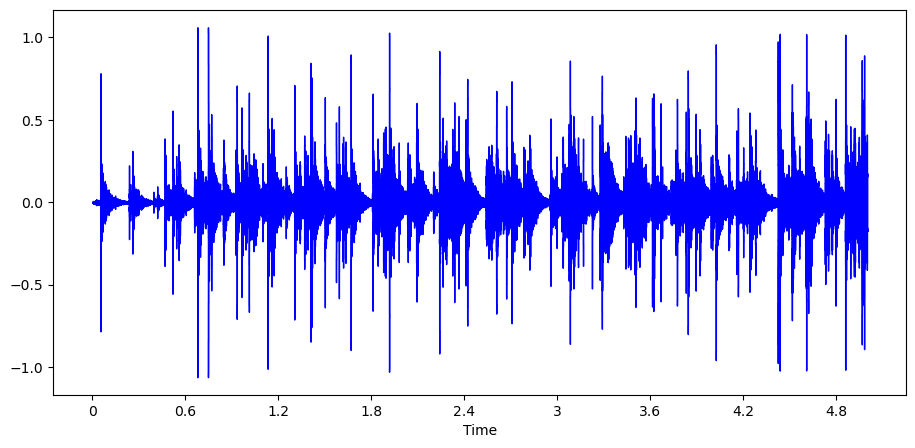

In [648]:
#
# Anzeige als PCM Kurven
#
displayIndex = 0
x_show = x_check[displayIndex]

plt.figure(figsize=(11, 5))
librosa.display.waveshow(x_show, sr=sampleRate, color="blue")

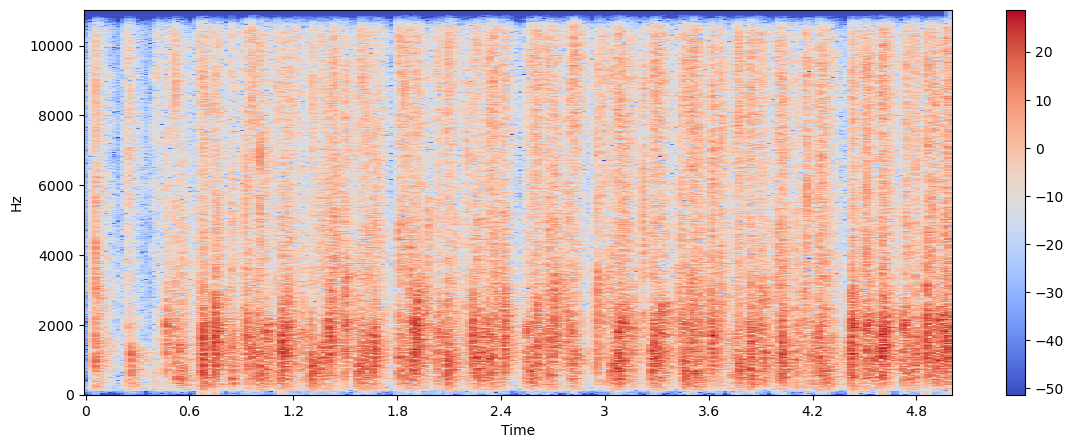

In [649]:
#
# Anzeige als Frequenzbänder über die Zeit
#
X = librosa.stft(x_show)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [650]:
from IPython.display import (
    Audio, display, clear_output)

In [651]:
display(Audio(x_show, rate=sampleRate, autoplay=True))

# Erzeugen der Trainingsdaten

https://en.wikipedia.org/wiki/Constant-Q_transform

<img src="info.png" align="left"/> 

In [652]:
#
# Berechnen der Featuretransformation für Audio
# cqt 
# 

# step size
window = 1024

# frequency pins
bins = 64

# features
features = 3

In [653]:

def get_cqt_features (file, hop, bins):
    
    y = np.zeros(sampleLen);   
    yt, sr = librosa.core.load (file, mono=True)
    
    if len(yt) == 0: 
        print ('found empty file ' + file )
        return 0

    min_length = min(len(y), len(yt))
    y[:min_length] = yt[:min_length]
    
    # https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
    #C = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop, n_mfcc = bins)  

    #https://librosa.github.io/librosa/generated/librosa.core.cqt.html
    C = np.log1p( 1000 * np.abs (librosa.core.cqt( y=y, sr=sr, hop_length=hop, n_bins=bins)))
    
    return C


def get_all_features(filename, window, bins):
    # Load the audio file
    y, sr = librosa.load(filename, sr=None, mono=True)

    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=bins, n_fft=window, hop_length=window//2)

    # Compute Chroma-STFT
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=bins, n_fft=window, hop_length=window//2)

    # Compute specral centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    
    # Normalize features between 0 and 1
    mfcc_normalized = (mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc))
    chroma_stft_normalized = (chroma_stft - np.min(chroma_stft)) / (np.max(chroma_stft) - np.min(chroma_stft))
    spec_centroid_normalized = (spec_centroid - np.min(spec_centroid)) / (np.max(spec_centroid) - np.min(spec_centroid))

    # Resize features to the smallest dimension among them for stacking
    min_length = min(mfcc_normalized.shape[1], chroma_stft_normalized.shape[1], spec_centroid_normalized.shape[1])

    # has height of bins: use as reference hight: lenght is min_lenght
    mfcc_resized = mfcc_normalized[ : , :min_length]

    # has hight of 1, needs pading
    spec_centroid_resized = np.tile( spec_centroid_normalized[ : , :min_length], (bins, 1))

    # has height of bins
    chroma_stft_resized = chroma_stft_normalized[:, :min_length]

    
    
    # Stack the features to form a 3-channel image
    feature_image = np.stack([mfcc_resized, chroma_stft_resized, spec_centroid_resized], axis=-1)

    # Ensure the image is in the correct shape (height x width x 3)
    feature_image = np.moveaxis(feature_image, 0, 1)

    return feature_image







memory = joblib.Memory(verbose=0)
cached_get_features = memory.cache(get_all_features)


def compute_features (root_path):
        
    classes = 50
    samples = 0

    y_data = []    
    X_data = []
    
    for root, dir, files in os.walk(root_path):
        
        waves = fnmatch.filter(files, "*.wav")

        if len(waves) != 0:
            for item in waves:
                # e.g. 2-39443-A-19.wav
                fileName = os.path.splitext ( os.path.basename(item) )[0] 
                classID = int(fileName.split('-')[3])
                
                mfcc = cached_get_features( os.path.join(root, item), window, bins)
                print(".",end='')

                X_data.append(mfcc)
                y_data.append(classID)
                
                samples = samples + 1
                if samples >= 3000:
                    break

    X_data = np.stack(X_data)
    
    print()
    print('shape features {}'.format(X_data.shape))
    
    #X_data = np.transpose(X_data, (2,0,1))
    #d1 = X_data.shape[0]
    #d2 = X_data.shape[1]
    #d3 = X_data.shape[2]    
    #X_data = np.reshape(X_data, (d1,d2,d3,1))
    y_data = np.array(y_data)    

    print('shape transformed {}'.format(X_data.shape))
    print ("samples = " + str (samples) )

    return X_data, y_data, classes, samples

In [654]:
x_data, y_data, classes, samples = compute_features (audioData)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [655]:
x_data = x_data.astype('float32')
y_data = y_data.astype('uint8')

# Anzeige der Features als Bild

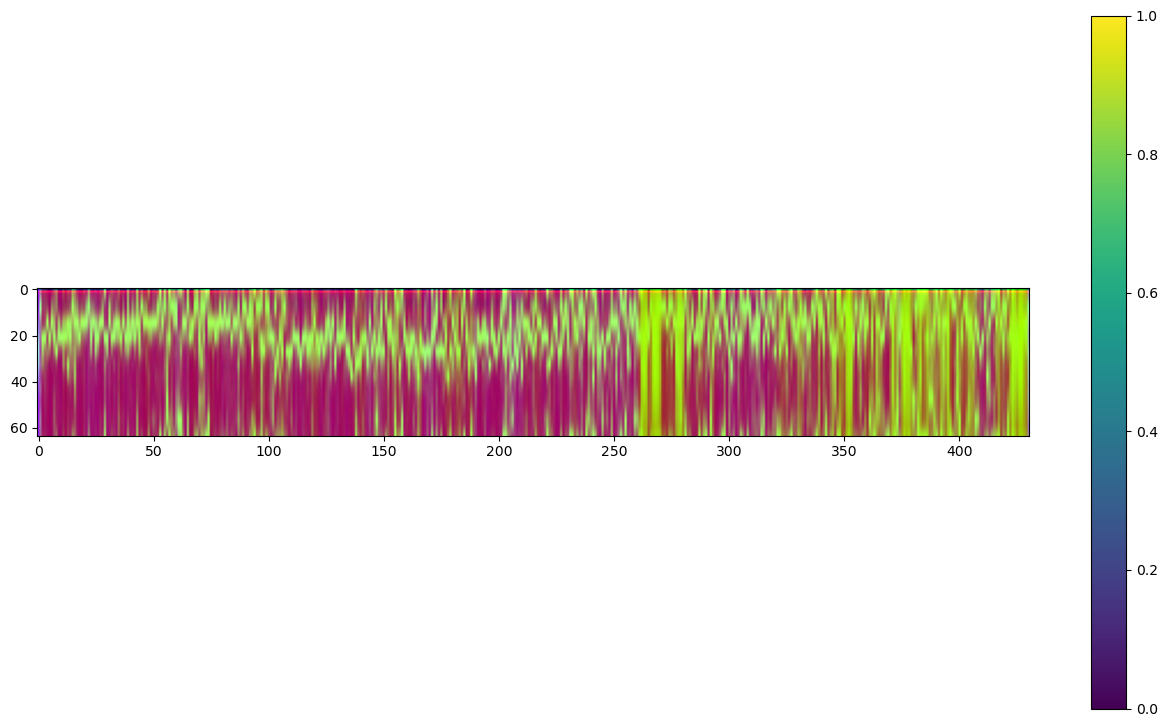

In [656]:
x_show = x_data[displayIndex]
x_show = np.transpose(x_show,(1,0,2))
plt.imshow(x_show)
plt.colorbar()

# Anzeige der Klassenverteilung

In [657]:
y_data[0:5]

array([22, 16,  9, 47, 42], dtype=uint8)

<Axes: >

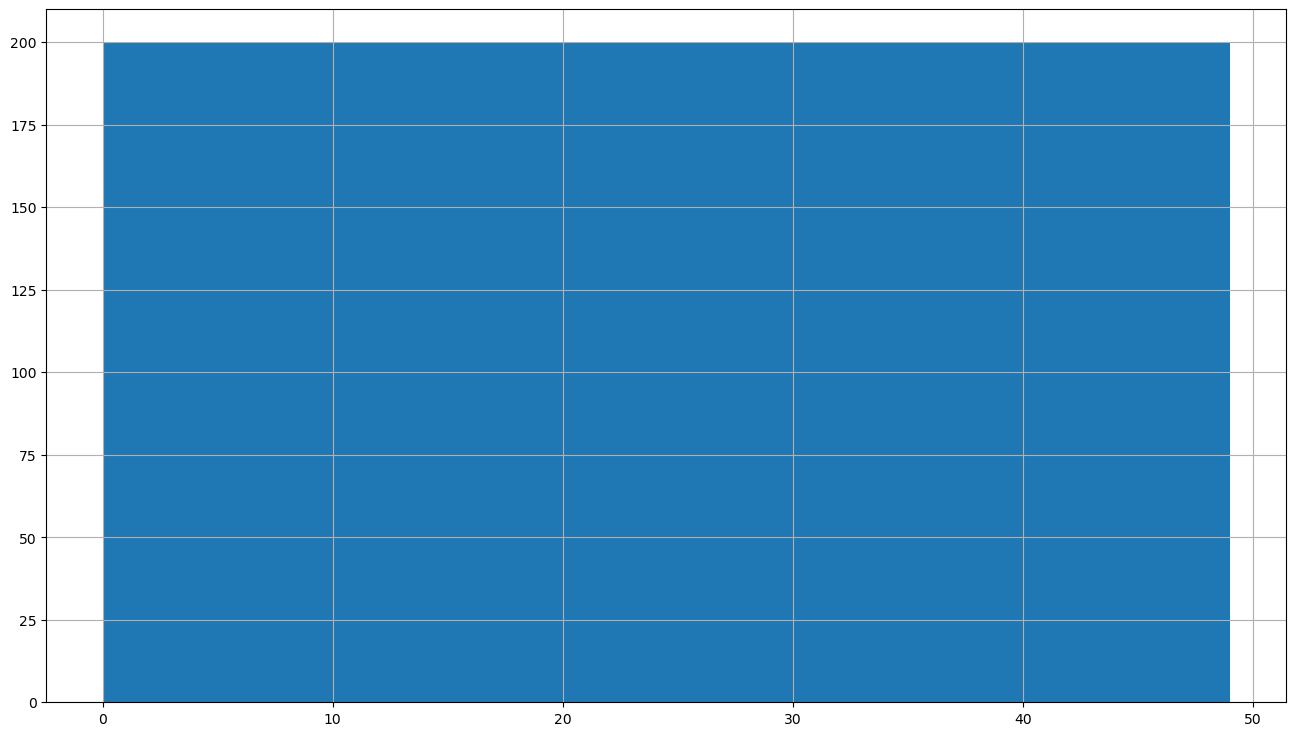

In [658]:
pd.DataFrame(y_data)[0].hist()

# Transformieren der Daten

In [681]:
#
# Normalisieren der Daten (Mittelwert = 0, Std Abweichung = 1)
# Alternativ: Skalierung der Daten zwischen 0 und 1
#

def standardize (x):
    mu = np.mean (x, axis=0)
    de = np.std (x, axis=0)   
    eps = np.finfo('float32').eps
    x = (x - mu) / (eps + (de*2.0) )
    
#    scaler = MinMaxScaler(feature_range=(0, 1) )
#    x = scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
    
    return x

In [682]:
x_data_std = standardize(x_data)
#x_data_std = x_data

In [683]:
# 
# Klassen in one-hot encoding umrechnen
#
y_data_onehot = to_categorical(y_data, classes )

In [684]:
y_data_onehot.shape

(2000, 50)

In [685]:
y_data_onehot[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

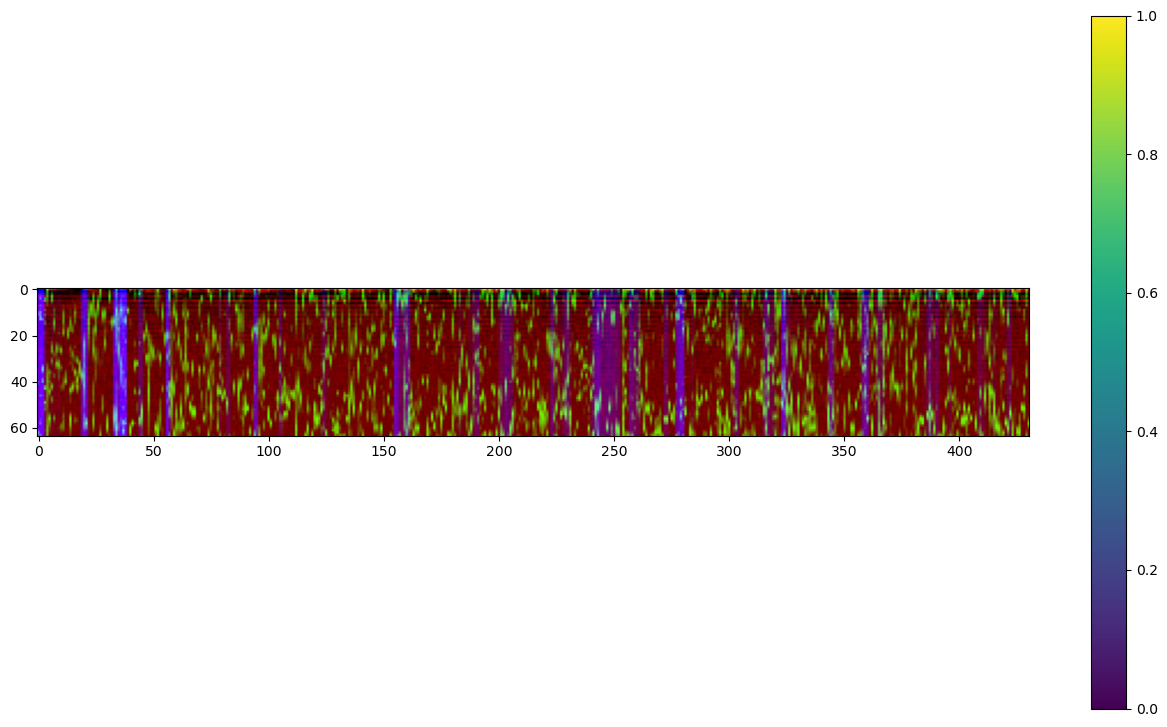

In [692]:
#
# Nochmals checken
#
x_show = x_data_std[displayIndex]
x_show = np.transpose(x_show,(1,0,2))
plt.imshow(x_show)
plt.colorbar()

# Train und Test Split

In [693]:
#
# Split der Daten in Train und Test(validation) Datensätze
#
x_train, x_validation, y_train, y_validation = train_test_split(x_data_std, y_data, test_size=0.10, random_state=42)

print('shapes {} {} {} {}'.format(x_train.shape, x_validation.shape, y_train.shape, y_validation.shape ))

shapes (1800, 431, 64, 3) (200, 431, 64, 3) (1800,) (200,)


# Model bauen

In [694]:
#
# Erzeugen eines einfache Modelles
#
def createModel():
    
    img_rows = x_train.shape[1]
    img_cols = x_train.shape[2]
    
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(img_rows, img_cols, features)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
     
    model.add(Convolution2D(64, kernel_size=3, strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Convolution2D(128, kernel_size=3, strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Convolution2D(128, kernel_size=3, strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    return model


In [695]:
#
# Anlegen des Modelles mit Beschreibung
#
model_cnn = createModel()
model_cnn.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 429, 62, 32)       896       
                                                                 
 batch_normalization_44 (Ba  (None, 429, 62, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 214, 31, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_62 (Dropout)        (None, 214, 31, 32)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 212, 29, 64)       18496     
                                                                 
 batch_normalization_45 (Ba  (None, 212, 29, 64)     

In [696]:
#
# Festlegen des Optimizers
#
optimizer = Adam (learning_rate=0.0001)


In [697]:
#model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_cnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=optimizer, metrics=['accuracy'])

In [700]:
#
# Anlegen des Datengenerators mit Augmentierung
#
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0.001,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

In [704]:
#
# Training des Generators
#
it_train = datagen.flow(x_train, y_train, batch_size=64)

In [705]:
callbacks = [History(),
             #EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
            ]

In [706]:
#
# Training des Modelles
#
steps = int(x_train.shape[0] / 64)
history = model_cnn.fit(it_train,
                            steps_per_epoch=steps,
                            epochs=100, 
                            callbacks=callbacks,
                            validation_data=(x_validation, y_validation))

Epoch 1/100
28/28 [==============================] - 20s 686ms/step - loss: 3.1301 - accuracy: 0.1809 - val_loss: 4.3859 - val_accuracy: 0.0200
Epoch 2/100
28/28 [==============================] - 20s 696ms/step - loss: 2.8709 - accuracy: 0.2362 - val_loss: 4.5286 - val_accuracy: 0.0400
Epoch 3/100
28/28 [==============================] - 20s 710ms/step - loss: 2.7118 - accuracy: 0.2609 - val_loss: 4.5665 - val_accuracy: 0.0250
Epoch 4/100
28/28 [==============================] - 21s 743ms/step - loss: 2.6234 - accuracy: 0.2788 - val_loss: 4.6268 - val_accuracy: 0.0400
Epoch 5/100
28/28 [==============================] - 30s 1s/step - loss: 2.4404 - accuracy: 0.3387 - val_loss: 4.6951 - val_accuracy: 0.0400
Epoch 6/100
28/28 [==============================] - 43s 2s/step - loss: 2.2917 - accuracy: 0.3537 - val_loss: 4.6717 - val_accuracy: 0.0450
Epoch 7/100
28/28 [==============================] - 37s 1s/step - loss: 2.1622 - accuracy: 0.3888 - val_loss: 4.6466 - val_accuracy: 0.0400
E

In [707]:
#
# Prüfung des Modelles
#
score = model_cnn.evaluate(x_validation, y_validation, verbose=0)
print("validation {} {:.3f}" .format(model_cnn.metrics_names[1], score[1]))

validation accuracy 0.295


In [708]:
#
# Ausgabe des Trainingsverlaufes
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='green', label='test')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='green', label='test')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

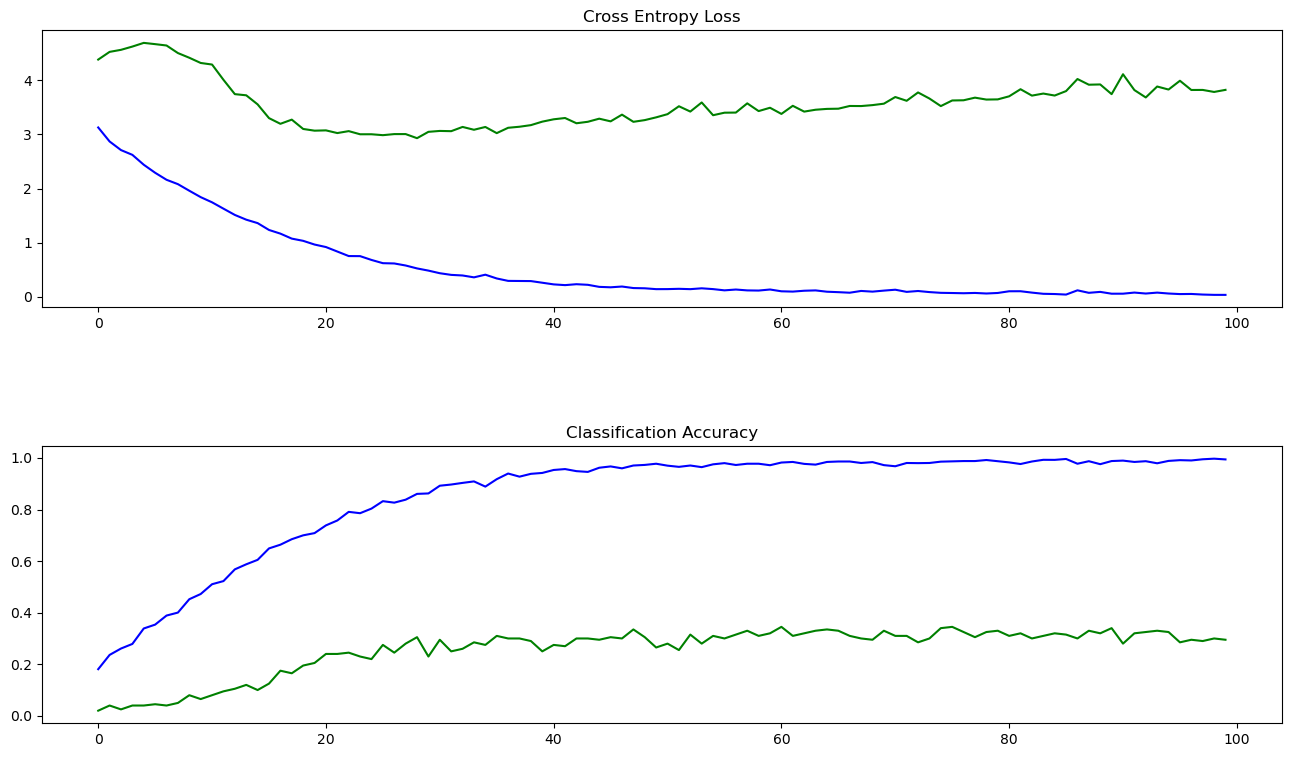

In [709]:
summarize_diagnostics(history,'06_model_cnn')

In [710]:
#
# Speichern des Modelles
#
from keras.models import model_from_json
prefix = 'results/06_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

In [711]:
if True:
    model_json = model_cnn.to_json()
    with open( modelName , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model_cnn.save_weights( weightName )
    print("saved model to disk as {} {}".format(modelName,weightName))

saved model to disk as results/06_model.json results/06_model.h5


In [712]:
#
# Laden eines vortrainierten Modelles
#
if False:
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_cnn = model_from_json(loaded_model_json)
    # load weights into new model
    model_cnn.load_weights(weightName)
    model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print("loaded model from disk")

In [713]:
# 
# evaluate loaded model on test data
#
score = model_cnn.evaluate(x_validation, y_validation, verbose=0)
print("%s: %.2f%%" % (model_cnn.metrics_names[1], score[1]*100))

accuracy: 29.50%


In [714]:
#
# Wie sind die Fehler verteilt?
#

In [715]:
y_pred = model_cnn.predict(x_validation)

7/7 [==============================] - 1s 76ms/step


In [716]:
y_pred = np.argmax(y_pred, axis=1)
y_true = y_validation

In [720]:
print(y_pred[:20])

[47 47 14 37 25 27 20  5 20 35 46 36 15  3 12 23  1 14 42 40]


In [721]:
print(y_true[:20])

[22 33 25  1 48  4 39 26 33 44 46 41 15 29 12 22 20 13 42 35]


<Axes: >

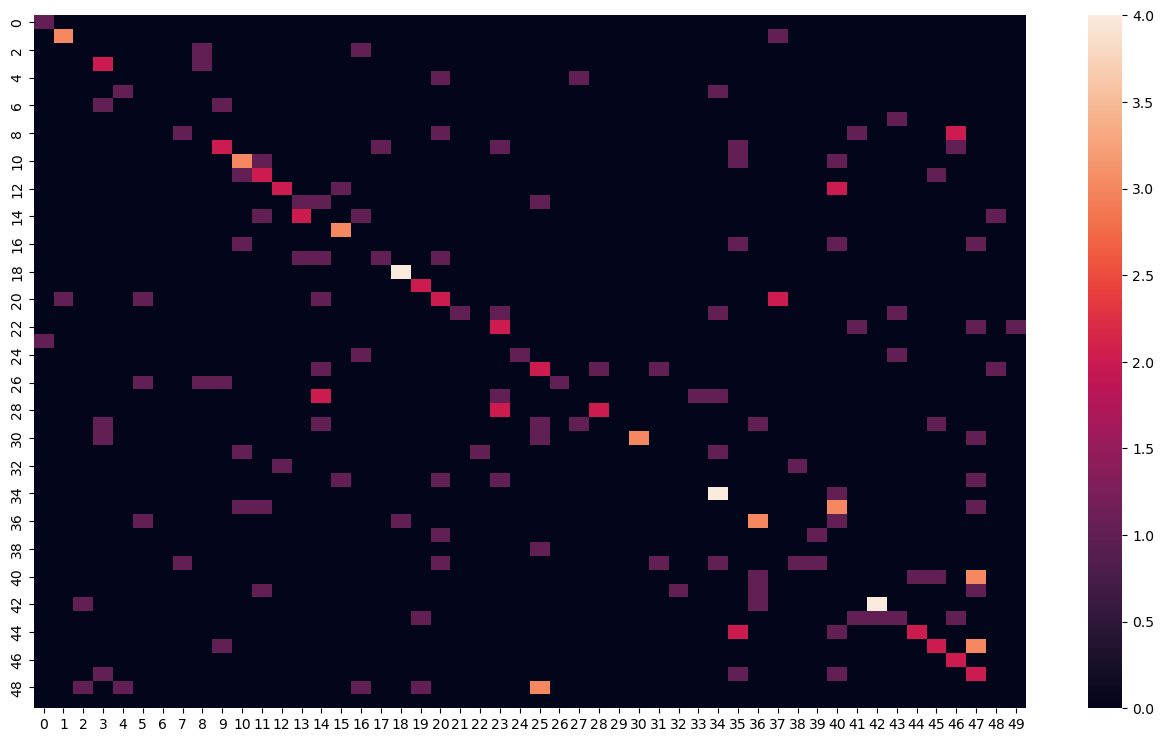

In [717]:
cf_matrix = np.clip(confusion_matrix(y_true, y_pred), 0, 20)
sns.heatmap(cf_matrix)